In [ ]:
from river.datasets import Insects
from river.preprocessing import MinMaxScaler 
from river.metrics import Accuracy
from river.utils import Rolling
from river.tree import HoeffdingTreeClassifier
from river_torch.classification import Classifier
from torch import nn 
from tqdm import tqdm 
import matplotlib.pyplot as plt
import matplotlib
import torch

In [ ]:
insects = Insects("abrupt_balanced")

def test_train_eval(model, stream, update_interval=100):
    results = []
    steps = []
    step = 0
    metric = Rolling(Accuracy(), window_size=400)
    scaler = MinMaxScaler()
    for x, y in tqdm(list(stream)):
        x = scaler.learn_one(x).transform_one(x)
        y_pred = model.predict_one(x)
        model.learn_one(x, y)
        metric.update(y, y_pred)
        step += 1
        if step % update_interval == 0:
            results.append(metric.get())
            steps.append(step)
    return steps, results

In [ ]:
class SimpleMLP(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.hidden1 = nn.Linear(n_features, 30)
        self.hidden2 = nn.Linear(30, 30)
        self.logits = nn.Linear(30, 6)

    def forward(self, x):
        h = torch.relu(self.hidden1(x))
        h = torch.relu(self.hidden2(h))
        return self.logits(h)


mlp = Classifier(
    SimpleMLP,
    loss_fn="binary_cross_entropy_with_logits",
    optimizer_fn="sgd",
    lr=0.05,
    seed=42,
)
steps, results_mlp = test_train_eval(mlp, insects)


100%|██████████| 355275/355275 [04:27<00:00, 1327.40it/s]


In [ ]:
tree = HoeffdingTreeClassifier()
steps, results_tree = test_train_eval(tree, insects)

100%|██████████| 355275/355275 [04:27<00:00, 1327.32it/s]


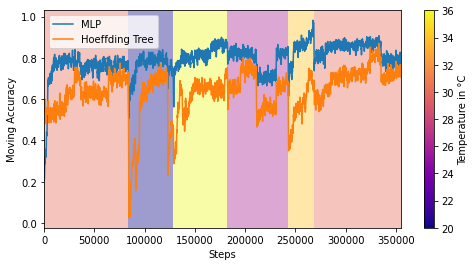

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(steps, results_mlp, label="MLP")
ax.plot(steps, results_tree, label="Hoeffding Tree")

change_points = [0, 14352, 19500, 33240, 38682, 39510, 52848]
temps = [30, 20, 36, 26, 34, 30]
cmap = plt.cm.plasma
norm = matplotlib.colors.Normalize(vmin=20, vmax=36)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
for i in range(len(change_points)-1):
    ax.axvspan(change_points[i], change_points[i+1], alpha=0.4, color=cmap(norm(temps[i])), lw=0)
ax.set_xlim(0, change_points[-1])
cbar = fig.colorbar(sm, ax=ax)
cbar.ax.set_ylabel("Temperature in °C")
ax.set_xlabel("Steps")
ax.set_ylabel("Moving Accuracy")
ax.legend()